# Plotting rhythms: raster, phase, polar and ratio plots

*Bas Cornelissen, 30 September 2020*

*This notebook came out of [a meeting of the Music Cognition Reading Group](https://musicreadinggroup.wordpress.com/2020/09/11/categorical-rhythm-in-songbirds/), and includes suggestions from Henkjan Honing, Carel ten Cate and John Ashley Burgoyne.*

**Are rhythms in human music similarly organized as rhythms in the songs of songbirds? In a recent article Tina Roeske and colleagues conclude that *categorical rhythms are shared between songbirds and humans*. Their analysis makes use of an interesting type of plot they call the *rhythm raster plots*. In this notebook we look at these plots in more detail.**

**Data.** To run this notebook, you need to download the data from https://data.mendeley.com/datasets/s4cjj7h5sv/2 and https://data.mendeley.com/datasets/zhb728dc4z/1 and put it in a data/ directory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import sys
sys.path.append('../')
from rhythmplot import *
from rhythmplot.helpers import drop_na

# Directory to all data of Roeske et al 2020
DATA_DIR = '../data/roeske2020'

# Function to save figures: you can easily toggle this on/off globally
kws = dict(dir='figures/roeske2020', save_pdf=True, save_png=True)
save_raster = get_figure_saver(group='raster-plots', **kws)
save_phase = get_figure_saver(group='phase-plots', **kws)
save_polar = get_figure_saver(group='polar-plots', **kws)
save_ratio = get_figure_saver(group='ratio-plots', **kws)
save_hexbin = get_figure_saver(group='hexbin-ratio-plots', **kws)
save_combined = get_figure_saver(group='combined-plots', **kws)

In [2]:
DATA = dict(
    cuban_salsa = load_intervals('roeske2020', 'cuban_salsa') * 1000,
    malian_jembe = load_intervals('roeske2020', 'malian_jembe') * 1000,
    north_indian_raga =load_intervals('roeske2020', 'north_indian_raga') * 1000,
    persian_zarb = load_intervals('roeske2020', 'persian_zarb') * 1000,
    western_piano = load_intervals('roeske2020', 'western_piano') * 1000,
    tunisian_stambeli = load_intervals('roeske2020', 'tunisian_stambeli') * 1000,
    uruguayan_candombe = load_intervals('roeske2020', 'uruguayan_candombe') * 1000,  
)

## Raster plots

The starting point is a sequence of intervals $i_1, i_2, \dots$ between onsets. 
These can be onsets of song syllables, or of notes in a music recording.
To create their raster plots, the authors look at pairs of consecutive intervals (see figure 1a).
Importantly, they order these pairs so that the first item is always the shortest interval of the two.
Take the intervals $i_j$ and $i_{j+1}$.
If $i_{j+1} \le i_j$ then the $j$-th pair becomes $p_j = (i_{j+1}, i_j)$.
Generally, we write $p = (i_S, i_L)$ for a pair consisting of a shorter and longer interval.
In the raster plot (figure 1b), all these pairs are shown, but sorted by their total cycle duration $\text{cd} = i_S + i_L$.
Longer or slower cycles are shown at the top, and shorter, faster cycles at the bottom of the plot.
Every pair is represented by two points at the same 'row' of the plot.
The shortest interval $i_S$ is plotted on the left, and the longer interval $i_L$ is plotted on the right side.

![title](media/fig1a.jpg)

**Figure 1** *Construction of the raster plots; copied from from Roeske et al (2020)*

The raster plot really shows two overlapping plots with flipped axes. 
One axis for the short intervals, running from 1000ms to 0ms in figure 1b, and one axis for long intervals running the other direction, from 0ms to 1000ms.
Temporal intervals cannot have a duration shorter than zero, so the two plots don't overlap.
But to get some more insight in how these plots work, we will look at general, random sequences of 'intervals' that can take any value.

In [3]:
def raster_points(intervals):
    points = []
    for a, b in zip(intervals[0:], intervals[1:]):
        duration = np.abs(a) + np.abs(b)
        if a <= b:
            points.append([a, b, duration])
        else:
            points.append([b, a, duration])
    return np.asarray(sorted(points, key=lambda p: p[2], reverse=True))

In [4]:
def raster_plot(intervals, large_color='C0', small_color='C3',
                left=None, right=None,
                large_label='larger interval',
                small_label='smaller interval',
                s=.25, alpha=0.25, marker='o',
                **kwargs):
    # Plot properties
    props = dict(s=s, alpha=alpha, marker=marker, edgecolors='none', **kwargs)
    points = raster_points(intervals)
    ys = np.arange(0, -len(points), -1)
    
    # Let matplotlib work out the xlims
    leftmost = points[:, 0].max()
    rightmost = points[:, 1].max()
    plt.plot([-1*leftmost, rightmost], [0,0], '.', alpha=0)
    auto_left, auto_right = plt.xlim()
    if left is None: left = auto_left
    if right is None: right = auto_right
    
    # Zero line
    plt.plot([0, 0], [ys[0], ys[-1]], 'k--', lw=1)

    # Large intervals
    large_ax = plt.gca()
    large_ax.set_xlim(left, right)
    large_ax.scatter(points[:, 1], ys, color=large_color, **props)
    large_ax.tick_params(axis='x', labelcolor=large_color)
    large_ax.set_xlabel(large_label, color=large_color) 
    
    # Small intervals
    small_ax = large_ax.twiny()
    small_ax.set_xlim(-left, -right)
    small_ax.tick_params(axis='x', labelcolor=small_color)
    small_ax.set_xlabel(small_label, color=small_color) 
    small_ax.scatter(points[:, 0], ys, color=small_color, **props)

    # Format the spines
    small_ax.spines['top'].set_color(small_color)
    small_ax.spines['top'].set_linewidth(2)
    small_ax.spines['bottom'].set_color(large_color)
    small_ax.spines['bottom'].set_linewidth(2)
    small_ax.spines['left'].set_linewidth(False)
    large_ax.spines['left'].set_linewidth(False)
    small_ax.spines['right'].set_visible(False)
    large_ax.spines['right'].set_visible(False) 
    plt.yticks([])

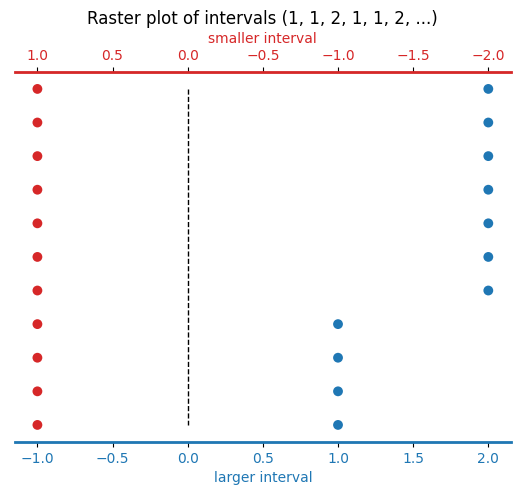

In [6]:
intervals = [1, 1, 2,   1, 1, 2,   1, 1, 2,   1, 1, 2]
raster_plot(intervals, s=50, alpha=1)
plt.title('Raster plot of intervals (1, 1, 2, 1, 1, 2, ...)');
save_raster('example')

Here's an example with some more data: (the absolute value of) 50,000 normally distributed intervals ($\mu=10, \sigma=2$):

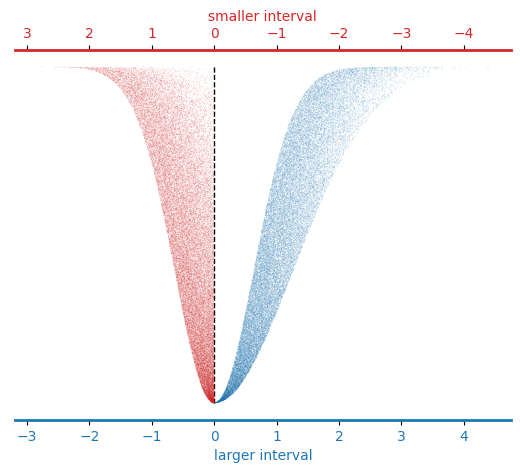

In [7]:
raster_plot(np.abs(np.random.normal(0, 1, 50000)))
save_raster('random-abs-normal')

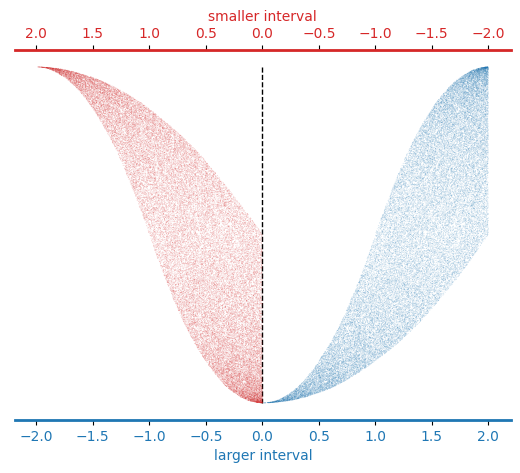

In [8]:
# Here's a uniform distribution
# the boundaries are caused by the boundaries of the uniform distribution:
raster_plot(np.random.uniform(0, 2, size=50000))
save_raster('raster-plot-random-uniform')

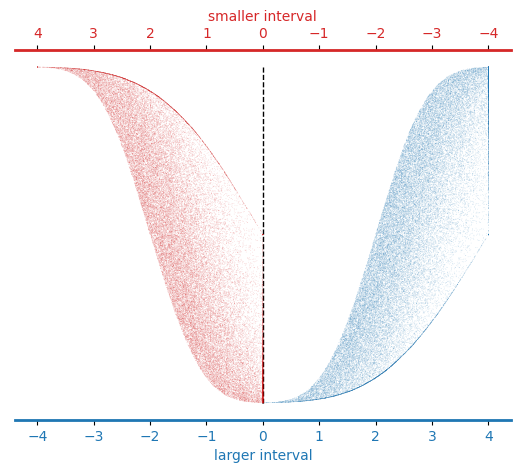

In [9]:
# They also appear if we clip a normal distribution:
raster_plot(np.clip(np.random.normal(2, 1, 50000), 0, 4))

This figure illustrates that the tulip-like shape of the graph is not of special interest (even though it looks nice).
We should mostly focus on how the rhythms are distributed *within the tulip*. 
Then we see that actual rhythms (obviously) cluster much more than the random intervals shown above.
Moreover, there seem to be differences between cultures:

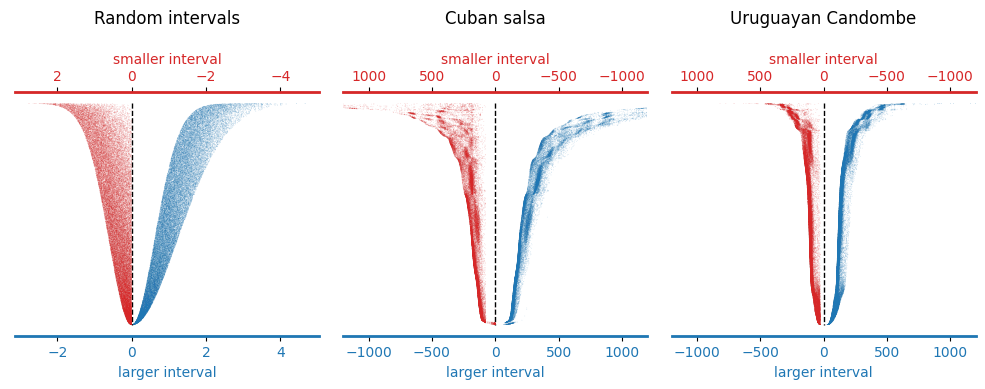

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(131)
raster_plot(np.abs(np.random.normal(0,1, size=50000)))
plt.title('Random intervals\n');

plt.subplot(132)
raster_plot(DATA['cuban_salsa'], left=-1200, right=1200)
plt.title('Cuban salsa\n');

plt.subplot(133)
raster_plot(DATA['uruguayan_candombe'], left=-1200, right=1200)
plt.title('Uruguayan Candombe\n');

plt.tight_layout()
save_raster('raster-plots')

Although the raster plots look nice, interpreting them is difficult.
First, the two different horizontal axes can be confusing.
Second, the vertical axis corresponds to cycle duration, but has dimension: it is really the order of the cycles. 
This could, however, be fixed by using a heatmap or hexbin plot.
But third and perhaps most importantly, it is not easy to see where different types of rhythms can be found. 
Fortunately, the authors included a helpful figure in their paper:

<img src="/media/fig1b.jpg" style="max-width: 500px;"/>

**Figure 1b** *Small ratio rhythms in a raster plot*

Here we can see that the isochronous rhyhms lie on left-edge of the red side of the plot (the red petal), but also on the left side of the blue petal. That makes sense, since their distance to 0 should be equally large. 
The 1:2 rhythms lie to the right of 1:1 in both petals, and the 1:3 yet more to the right.
This helps, but the plots remain complicated. 
Are there no simpler alternatives?

## Phase plots

Henkjan Honing suggested to so called *phase plots* in which you plot the duration of every interval $i_j$ against the duration of the next interval $i_{j+1}$. Here's a simple example of the a regular rhythm with inter-onset intervals 1, 1, 2, 1, 1, 2, ...:

In [11]:
def phase_points(intervals):
    pairs = zip(intervals[0:], intervals[1:])
    return np.asarray(list(pairs))

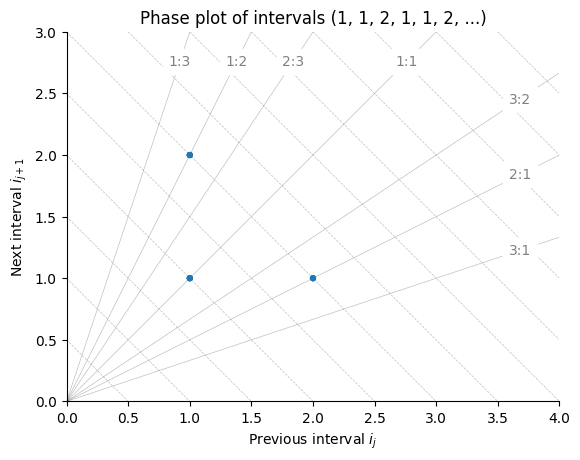

In [12]:
from itertools import combinations
def phase_plot(intervals, s=.25, alpha=.25, **kwargs):
    props = dict(s=s, alpha=alpha, marker='o', edgecolors='none', **kwargs)
    points = phase_points(intervals)
    plt.scatter(points[:, 0], points[:, 1], **props)
    plt.ylabel('Next interval $i_{j+1}$')
    plt.xlabel('Previous interval $i_j$')

    xlim = np.asarray(plt.xlim())
    ylim = np.asarray(plt.ylim())
    
    gridprops = dict(color='k', lw=.5, alpha=.25, zorder=-1)
    levels = 3
    line_points = list(combinations(range(1, levels + 1), 2))
    line_points += [[y, x] for x,y in line_points]
    line_points += [[1,1]]
    label_pad = 0.92
    for x, y in line_points:
        plt.axline([0,0], [x, y], **gridprops)
        if y >= x:
            text_y = label_pad * ylim[1]
            text_x = text_y / (y/x)
        else:
            text_x = label_pad * xlim[1]
            text_y = text_x * (y/x)        
        plt.text(text_x, text_y, f'{x}:{y}', backgroundcolor='#fff', color='0.5',
                 ha='center', va='center')
    
    ticks = list(plt.xticks()[0])
    ticks += [x + max(ticks) for x in ticks if x != 0]
    for tick in ticks:
        if tick == 0: continue
        plt.axline([0,tick], [tick, 0], ls='--', **gridprops)
        
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    sns.despine()
    plt.gca().set_aspect('equal')
    
    
intervals = [1, 1, 2,   1, 1, 2,   1, 1, 2,   1, 1, 2]
plt.xlim(0, 4)
plt.ylim(0, 3)
phase_plot(intervals, s=20, alpha=1)
plt.title('Phase plot of intervals (1, 1, 2, 1, 1, 2, ...)')
save_phase('example')

If we now turn to some actual music, we see that these plots are much easier to interpret:

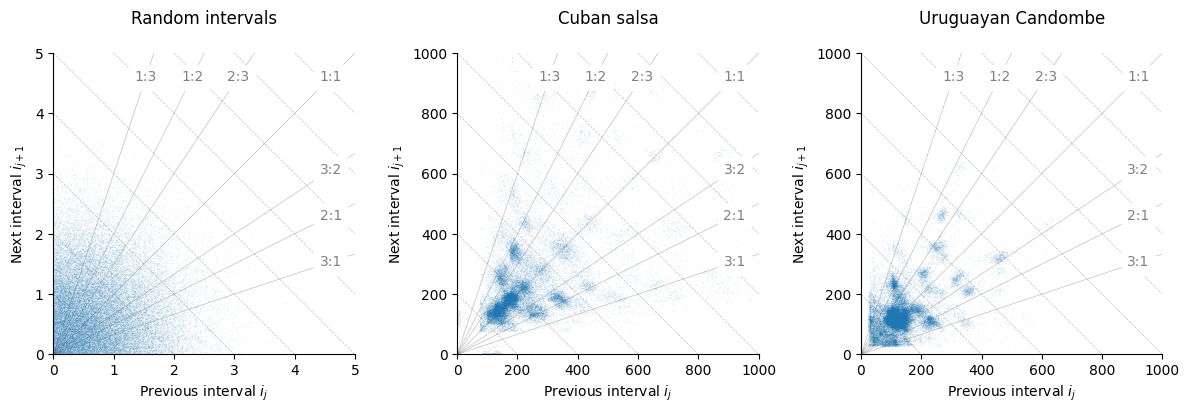

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.xlim(0, 5)
plt.ylim(0, 5)
phase_plot(np.abs(np.random.normal(0, 1, size=50000)))
plt.title('Random intervals\n');

plt.subplot(132)
plt.xlim(0, 1000)
plt.ylim(0, 1000)
phase_plot(DATA['cuban_salsa'])
plt.title('Cuban salsa\n');

plt.subplot(133)
plt.xlim(0, 1000)
plt.ylim(0, 1000)
phase_plot(DATA['uruguayan_candombe'])
plt.title('Uruguayan Candombe\n');

plt.tight_layout()
save_phase('random-salsa-candombe')

## Polar plot

Another way to plot this is to map $(a, b)$ to a point with radius $a+b$ and angle $\tan^{-1}(b/a)$ in a polar coordinate system. 
Then the points with equal cycle duration lie on circles, and ratio's correspond to angles.
It looks nice, but the phase plots above are probably easier to interpret.

In [14]:
def polar_points(intervals):
    """Convert intervals to a polar coordinates"""
    points = phase_points(intervals)
    r = points.sum(axis=1)
    theta = np.arctan(points[:, 1] / points[:, 0])
    return np.array([theta, r]).T

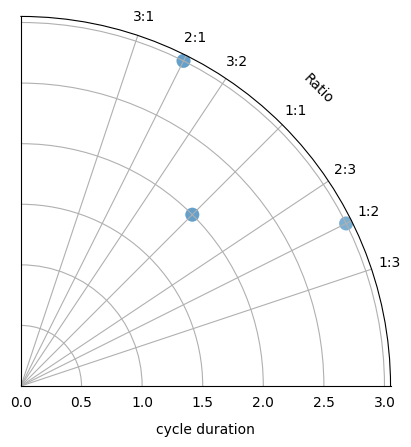

In [15]:
def polar_plot(intervals, ax=None, levels=3, s=.25, alpha=.25, labels=True, **kwargs):
    if ax is None: ax = plt.gcf().add_subplot(111, polar=True)    
    points = polar_points(intervals)
    props = dict(s=s, alpha=alpha, marker='o', edgecolors='none', **kwargs)
    ax.scatter(points[:, 0], points[:, 1], **props)

    # Set theta ticks: the ratios
    line_points = list(combinations(range(1, levels + 1), 2))
    line_points += [[y, x] for x,y in line_points] + [[1,1]]
    theta_ticks = [np.arctan(x/y) for x, y in line_points]
    theta_labels = [f'{x}:{y}' for x, y in line_points]
    plt.xticks(theta_ticks, theta_labels)
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    
    # Bit hacky: axis labels
    if labels:
        ax.text(0.5*np.sqrt(2) + .05, 0.5*np.sqrt(2) + .05, "Ratio",
                 rotation=-45, ha="left", va="bottom", transform=ax.transAxes)
        ax.text(.5, -.1, "cycle duration",
                 rotation=0, ha="center", va="top", transform=ax.transAxes)

intervals = [1, 1, 2,   1, 1, 2,   1, 1, 2,   1, 1, 2]
polar_plot(intervals, s=100)
save_polar('example')

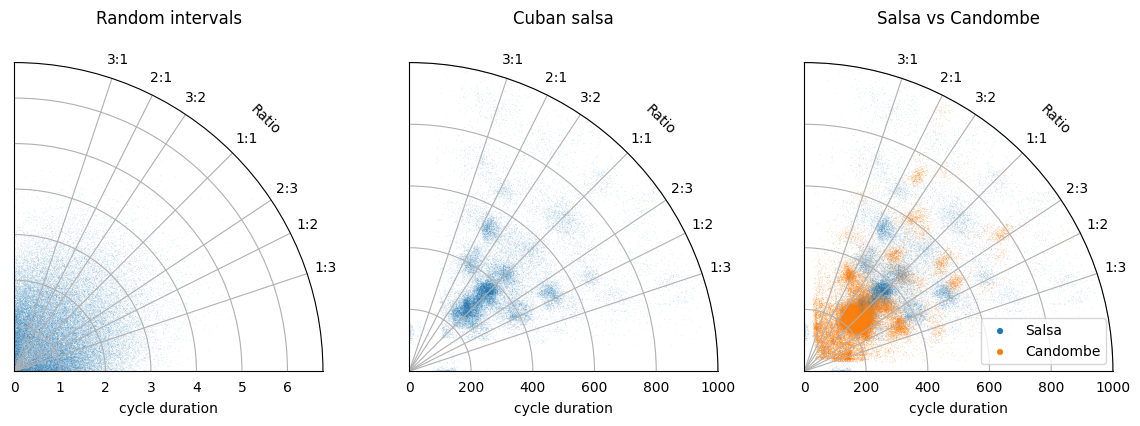

In [16]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(131, projection='polar')
polar_plot(np.abs(np.random.normal(0, 1, 50000)), ax=ax1)
plt.title('Random intervals\n');

ax2 = plt.subplot(132, projection='polar')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
polar_plot(DATA['cuban_salsa'], ax=ax2)
plt.title('Cuban salsa\n');

ax3 = plt.subplot(133, projection='polar')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
polar_plot(DATA['cuban_salsa'], ax=ax3, label='Salsa')
polar_plot(DATA['uruguayan_candombe'], ax=ax3, alpha=.5, label='Candombe', labels=False)
l = plt.legend()
for handle in l.legendHandles:
    handle.set_alpha(1)
    handle.set_sizes([20])
plt.title('Salsa vs Candombe\n');

plt.tight_layout()
save_polar('polar-plots')

## Ratio plot

A problem with the phase plots is that the plot is cluttered near the origin.
This can be resolved rescaling the plot in such a way that the diagonal lines for different ratio's become equally-spaced straight vertical lines.
For this we use the following function (only defined for positive $x$):
\begin{align}
f(x) = \begin{cases}
    x-1 &\text{if $x \ge 1$} \\
    \frac{-1}{x}+1 &\text{if $x < 1$}
\end{cases}
\end{align}
This function maps $\text{1:1} \mapsto 0$, and $\text{3:1} \mapsto 2$, while $\text{1:3} \mapsto -2$. 
This means that the zero line corresponds to isochronous rhythms, and ratio's $a:b$ on the right are mirrored by their inverse $b:a$ on the left. 
Moreover, the rhythms $\dots, \; \text{3:1},\; \text{2:1}, \;\text{1:1}, \;\text{1:2}, \;\text{1:3}, \;\dots$ are linearly spaced.
The following graph illustrates the scaling function $f$:

In [17]:
def scale(xs):
    xs = np.asarray(xs)
    ys = np.zeros(xs.shape)
    ys[xs<=0] = -np.inf
    ys[xs>=1] = xs[xs >= 1] - 1
    ys[(0 < xs) & (xs < 1)] = -1 / xs[(0 < xs) & (xs < 1)] + 1
    return ys

def scale_inv(ys):
    ys = np.asarray(ys)
    xs = np.zeros(ys.shape)
    xs[ys == -np.inf] = 0
    xs[ys < 0] = 1 / (-ys[ys < 0] + 1)
    xs[ys >= 0] = ys[ys >= 0] + 1
    return xs

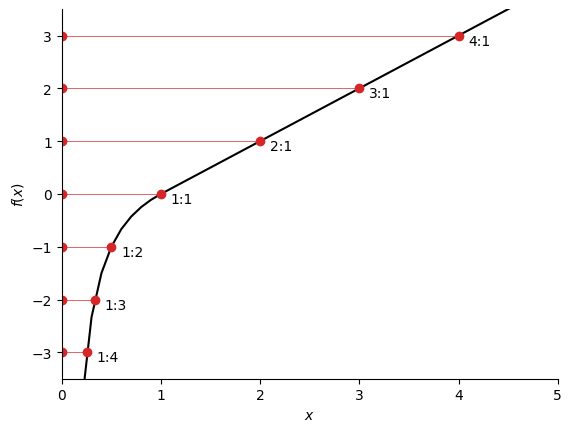

In [18]:
xs = np.linspace(1/10, 10, 100)
plt.plot(xs, scale(xs), 'k')
ratios = [(1, 1), (1, 2), (2, 1), (1, 3), (3, 1), (1, 4), (4, 1)]
for a, b in ratios:
    ratio = a/b
    plt.plot([0, ratio], [scale(ratio), scale(ratio)], c='C3', lw=.5)
    plt.plot([ratio], [scale(ratio)], 'o', c='C3')
    plt.plot([0], [scale(ratio)], 'o', c='C3')
    plt.text(ratio+.1, scale(ratio)-.1, f'{a}:{b}', ha='left', va='center')
plt.ylim(-3.5,3.5)
plt.xlim(0, 5)
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
sns.despine()
save_ratio('ratio-plot-scale')

If we use this function to scale the ratio, we get what we will call *ratio plots*:

In [19]:
def duration_ratio_points(intervals):
    points = []
    for a, b in zip(intervals[0:], intervals[1:]):
        points.append([a / b, a + b])
    return np.asarray(points)

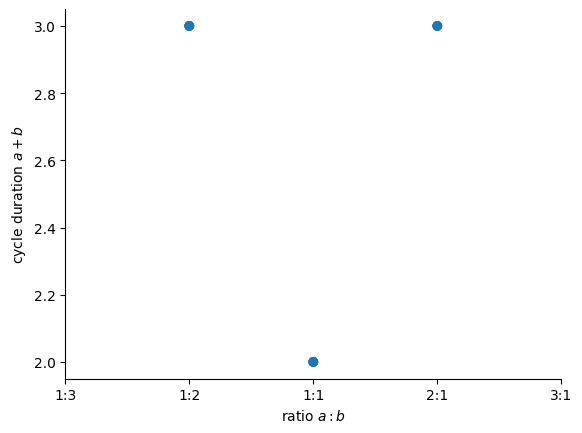

In [20]:
def ratio_plot(intervals, s=.5, alpha=.5, nmax=5, **kwargs):
    points = duration_ratio_points(intervals)
    props = dict(s=s, alpha=alpha, marker='o', edgecolors='none', **kwargs)
    plt.scatter(points[:, 0], points[:, 1], **props)
    plt.gca().set_xscale('function', functions=(scale, scale_inv))

    ticks = scale_inv(np.arange(-nmax, nmax+1))
    labels = ([f'1:{-n}' for n in range(-nmax-1, -1)] 
              + [f'{n}:1' for n in range(1, nmax+2)])
    plt.xticks(ticks, labels);
    plt.xlabel('ratio $a:b$')
    plt.ylabel('cycle duration $a+b$')
    sns.despine()
    
intervals = [1, 1, 2,   1, 1, 2,   1, 1, 2,   1, 1, 2]
ratio_plot(intervals, s=50, alpha=1)
plt.xlim(1/3, 3);
save_ratio('example')

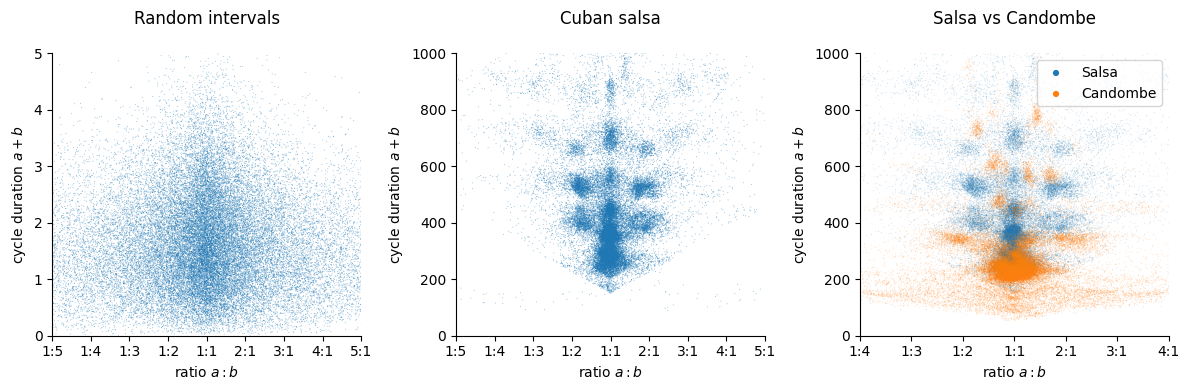

In [21]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(131)
ratio_plot(np.abs(np.random.normal(0, 1, 50000)))
plt.title('Random intervals\n');
plt.ylim(0, 5)
plt.xlim(1/5, 5)

ax2 = plt.subplot(132)
ratio_plot(DATA['cuban_salsa'])
plt.title('Cuban salsa\n');
plt.ylim(0,1000)
plt.xlim(1/5, 5)

ax3 = plt.subplot(133)
ratio_plot(DATA['cuban_salsa'], label='Salsa', alpha=.25)
ratio_plot(DATA['uruguayan_candombe'], label='Candombe', alpha=.25)
plt.ylim(0,1000)
plt.xlim(1/4, 4)
l = plt.legend()
for handle in l.legendHandles:
    handle.set_alpha(1)
    handle.set_sizes([20])
plt.title('Salsa vs Candombe\n');

plt.tight_layout()
save_ratio('random-salsa-candombe')

## Histogram ratio plots

A problem with scatterplots is that it is difficult to compare cluster sizes: one a region is fully coloured, adding ten times as many points to that region for example doesn't change its appearance. A solution is using hexbin plots. These are two dimensional histograms: the plane is tiled using hexagons, which are coloured according to the number of points in the hexagon.

The following example shows that relative cluster sizes really are hard to distinguish using scatter plots. Left we see the scatter plot, and in the center a histogram using a linear color map. Clearly, there is one massive cluster for a 1:1 rhythm with a duration of around 400ms, but this cannot be seen in the scatter plot. The other clusters are more clearly visible if we use a logarithmic color map (right).

In [22]:
import matplotlib.colors as colors
def hexbin_ratio_plot(intervals, max_duration=1000, max_ratio=2, nmax=10,
                      cbar=True, log_colors=True, cmap='GnBu', edgecolors='face', 
                      mincnt=1, linewidths=0.5, **kwargs):
    points = duration_ratio_points(intervals)
    durations = points[:, 1]
    ratios = scale(points[:, 0])
    selection = (durations < max_duration) & (-max_ratio < ratios) & (ratios < max_ratio)
    props = dict(cmap=cmap, edgecolors=edgecolors, linewidths=linewidths, mincnt=mincnt, **kwargs)
    if log_colors:
        props['norm'] = colors.LogNorm()
    hb = plt.hexbin(ratios[selection], durations[selection], **props)
    if cbar:
        plt.gcf().colorbar(hb, ax=plt.gca())
    
    nmax=3
    ticks = np.arange(-nmax, nmax+1)
    labels = ([f'1:{-n}' for n in range(-nmax-1, -1)] 
              + [f'{n}:1' for n in range(1, nmax+2)])
    plt.xticks(ticks, labels);
    plt.xlabel('ratio $a:b$')
    plt.ylabel('cycle duration $a+b$')

    plt.xlim(-max_ratio, max_ratio)
    plt.ylim(0, max_duration)
    sns.despine()
    plt.tight_layout()

# hexbin_ratio_plot(DATA['cuban_salsa'])

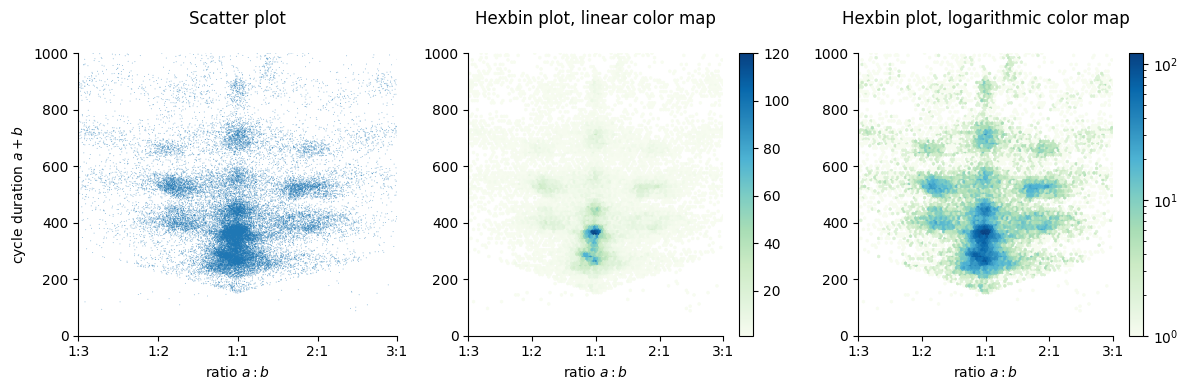

In [23]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(131)
ratio_plot(DATA['cuban_salsa'], label='Salsa')
plt.title('Scatter plot\n');
plt.xlim(1/3, 3)
plt.ylim(0, 1000)

ax = plt.subplot(132, sharey=ax1)
hexbin_ratio_plot(DATA['cuban_salsa'], log_colors=False)
plt.title('Hexbin plot, linear color map\n');
plt.ylabel(None)

ax = plt.subplot(133, sharey=ax1)
hexbin_ratio_plot(DATA['cuban_salsa'])
plt.title('Hexbin plot, logarithmic color map\n');
plt.ylabel(None)

plt.tight_layout()
save_hexbin('scatter-vs-hexbin')

## Combined plots

In [24]:
def plot_combined(intervals, title='', bound=None, **kwargs):
    plt.figure(figsize=(12, 5))
    
    ax1 = plt.subplot(131)
    leftbound = -1*bound if bound is not None else None
    raster_plot(intervals, left=leftbound, right=bound, **kwargs)
    
    ax2 = plt.subplot(132)
    if bound: plt.ylim(0, bound)
    if bound: plt.xlim(0, bound)
    phase_plot(intervals, **kwargs)
        
    ax3 = plt.subplot(133)
    hexbin_ratio_plot(intervals, max_duration=1.5*bound, **kwargs)
        
    plt.suptitle(title, fontweight='bold' )
    plt.tight_layout()

### Random

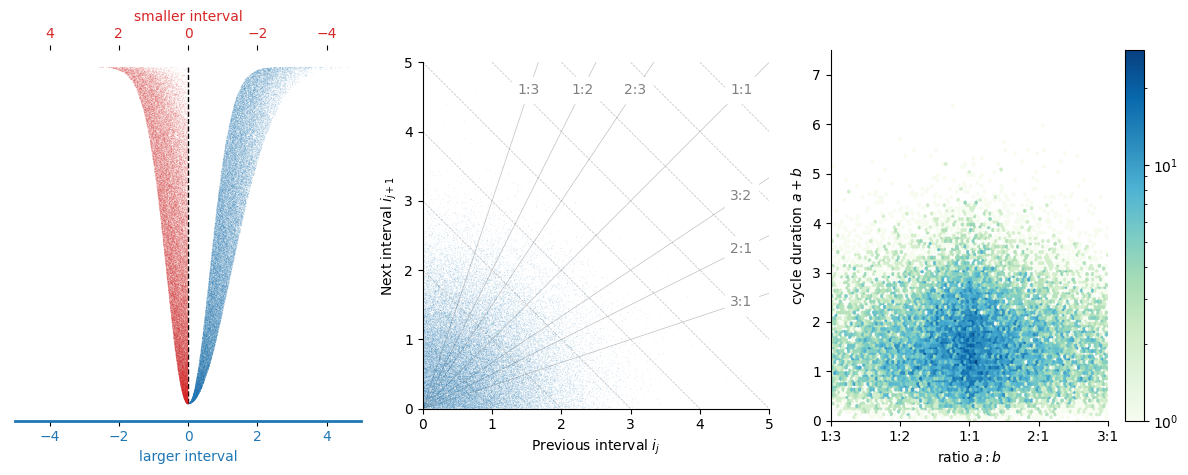

In [25]:
plot_combined(np.abs(np.random.normal(0, 1, 50000)), bound=5)
save_combined('random-abs-normal')

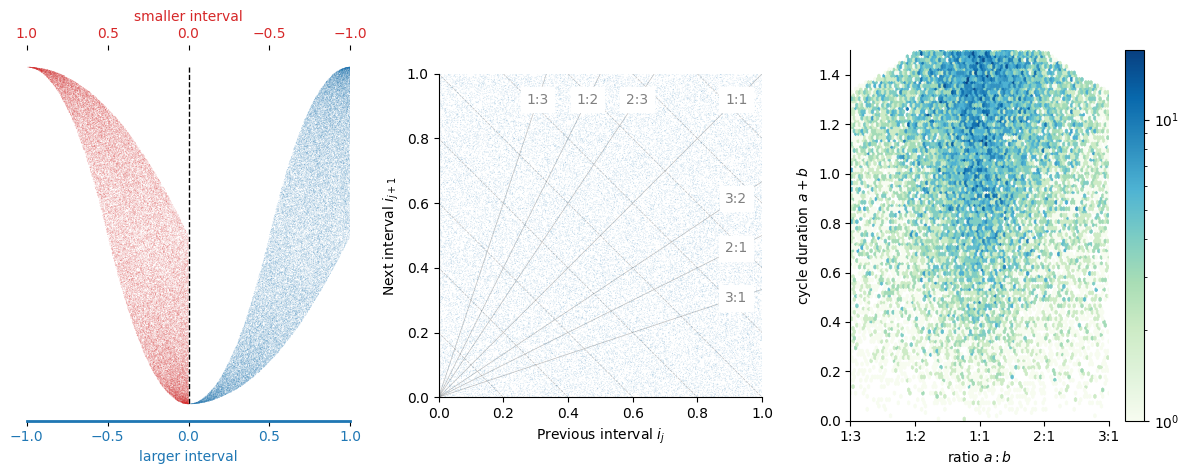

In [26]:
plot_combined(np.random.uniform(0, 1, 50000), bound=1)
save_combined('random-uniform')

### Musical traditions

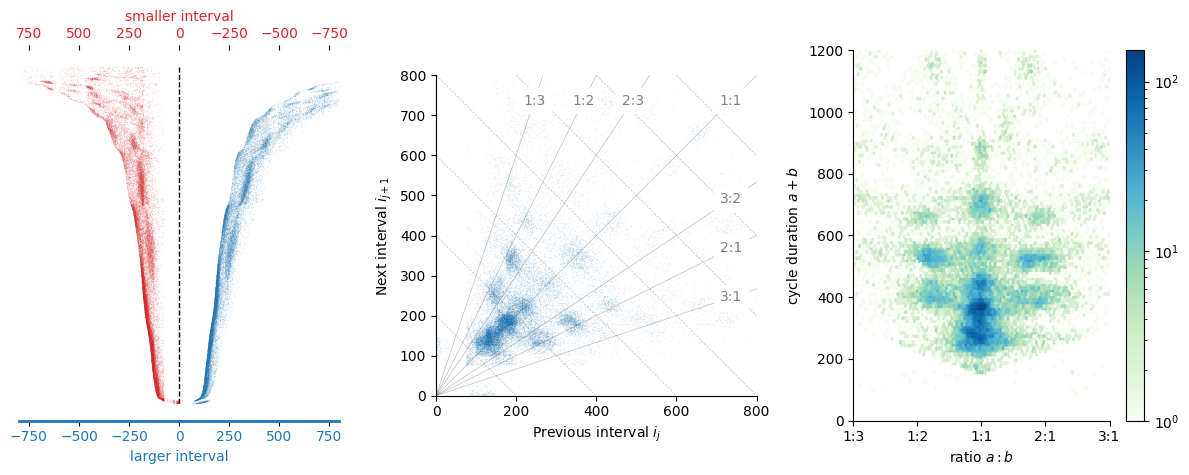

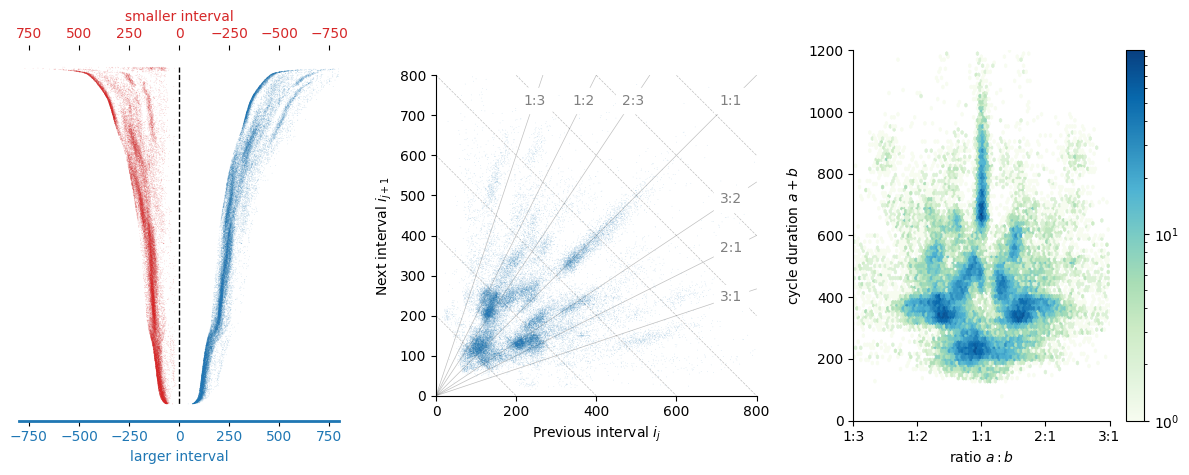

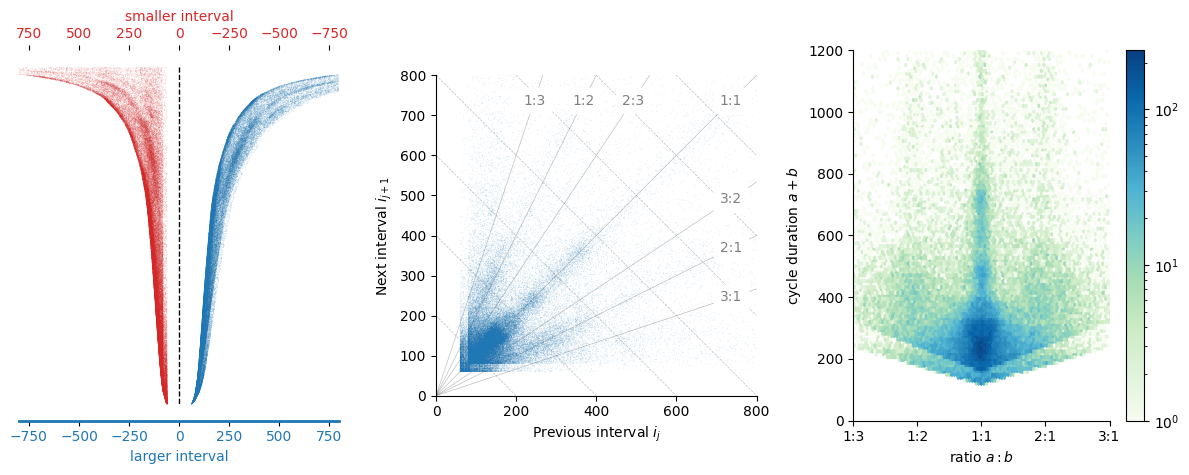

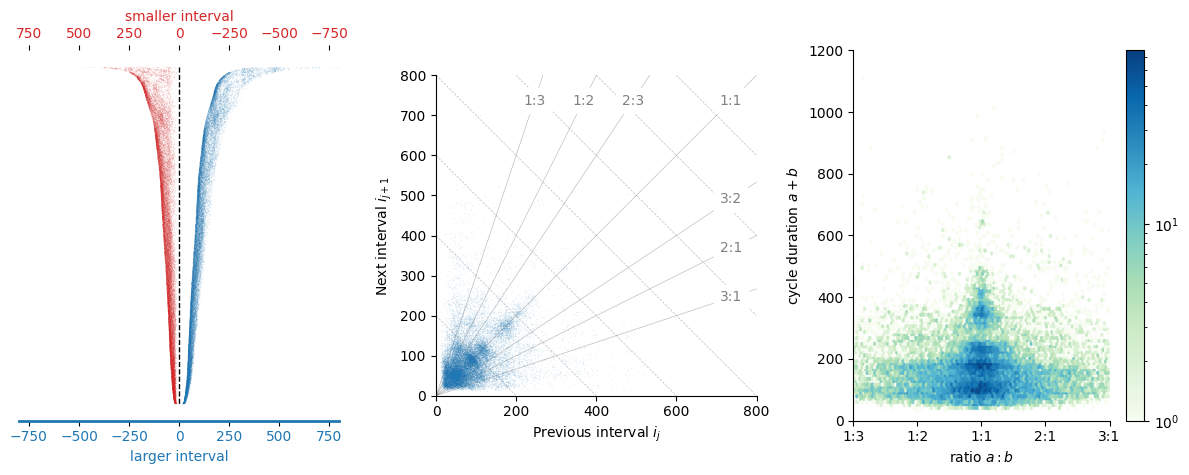

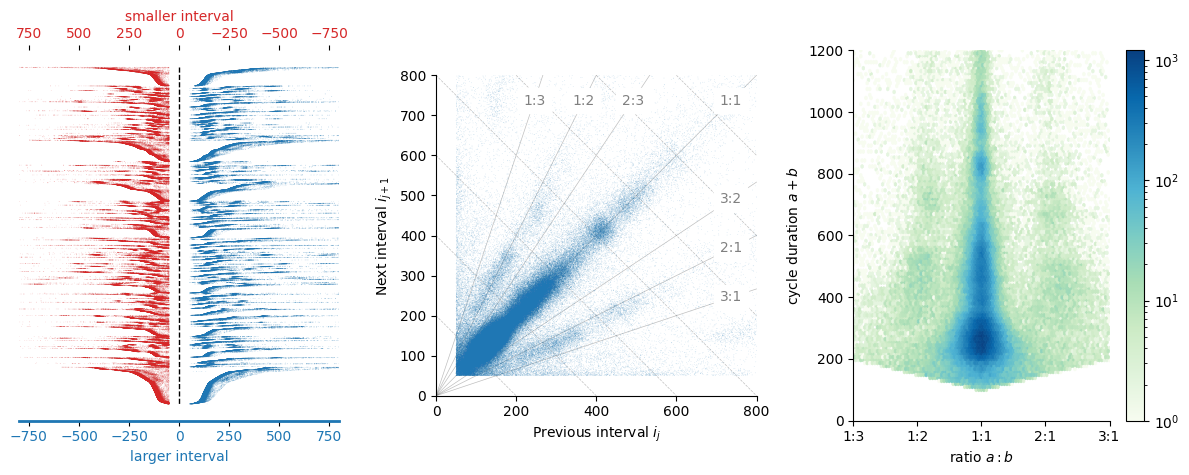

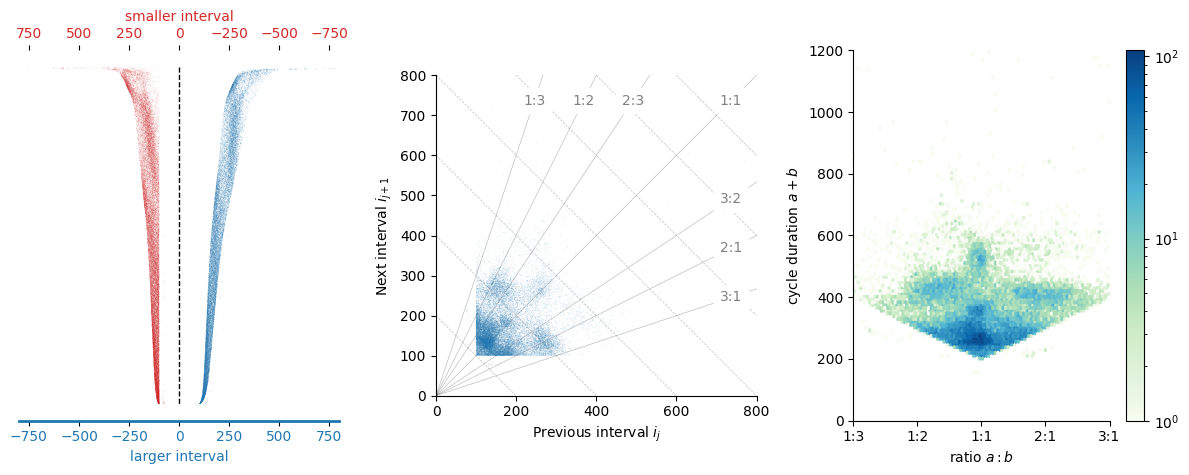

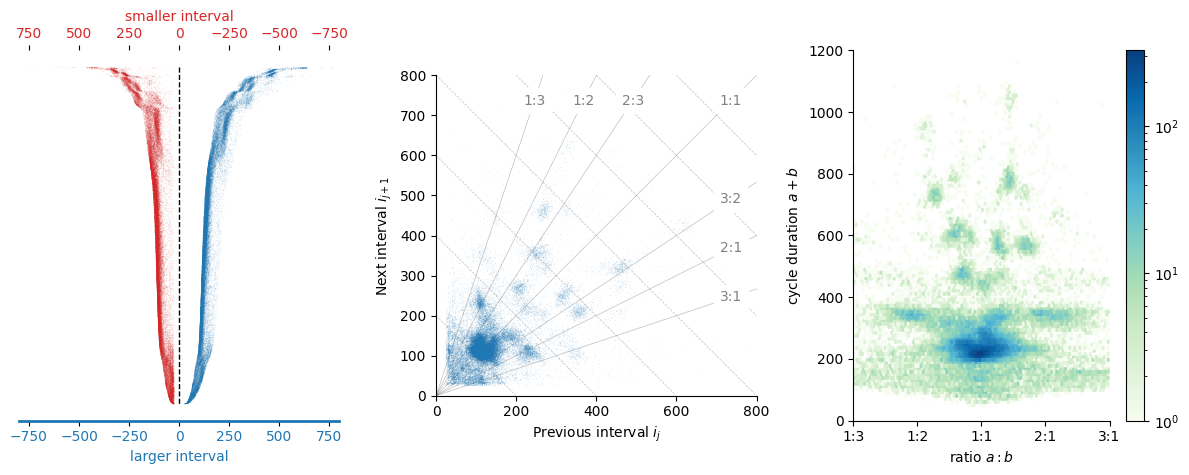

In [27]:
for corpus, intervals in DATA.items():
    plot_combined(intervals, bound=800)
    save_combined(corpus)

### Thrush Nightingale

In [35]:
nightingale_songs = load_intervals('roeske2020', 'nightingale_songs') * 1000
nightingale_stable = load_intervals('roeske2020', 'nightingale_stable') * 1000
nightingale_same_syll = load_intervals('roeske2020', 'nightingale_same_syll') * 1000

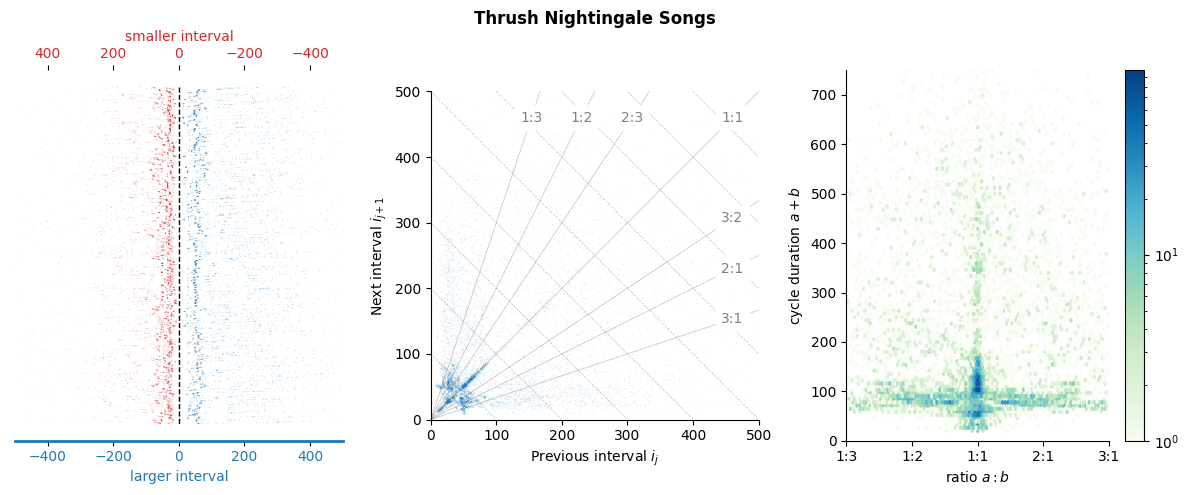

In [36]:
plot_combined(nightingale_songs, bound=500)
plt.suptitle('Thrush Nightingale Songs', fontweight='bold')
save_combined('nightingale-songs')

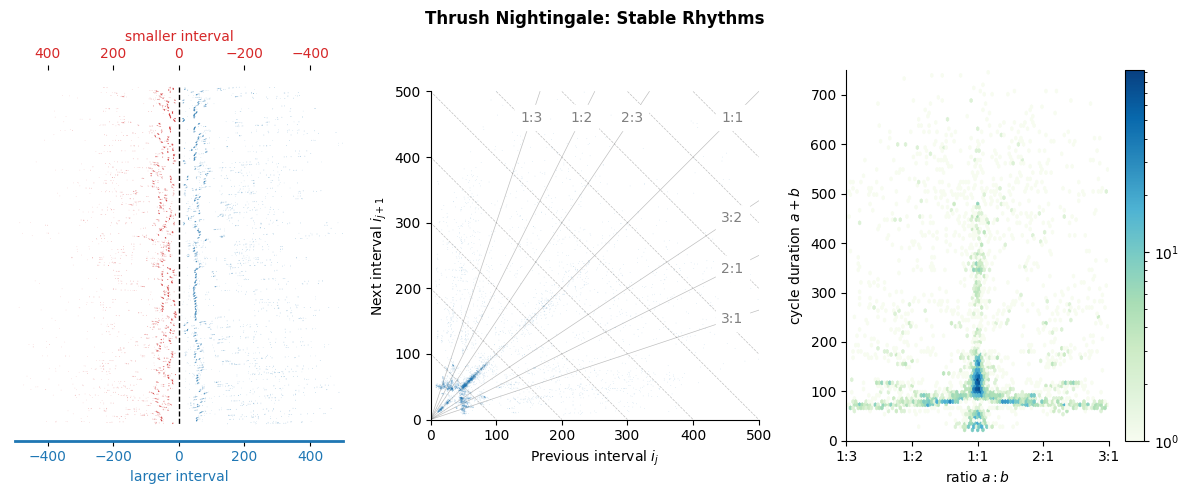

In [37]:
plot_combined(nightingale_stable, bound=500)
plt.suptitle('Thrush Nightingale: Stable Rhythms', fontweight='bold')
save_combined('nightingale-stable')

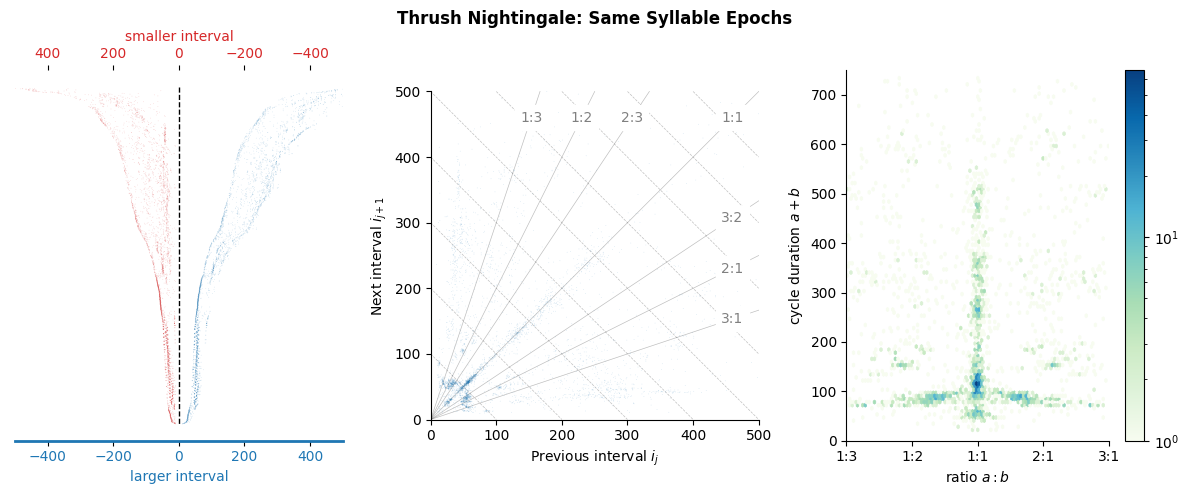

In [38]:
plot_combined(nightingale_same_syll, bound=500)
plt.suptitle('Thrush Nightingale: Same Syllable Epochs', fontweight='bold')
save_combined('nightingale-same-syll')

### Zebra Finch Rhythm

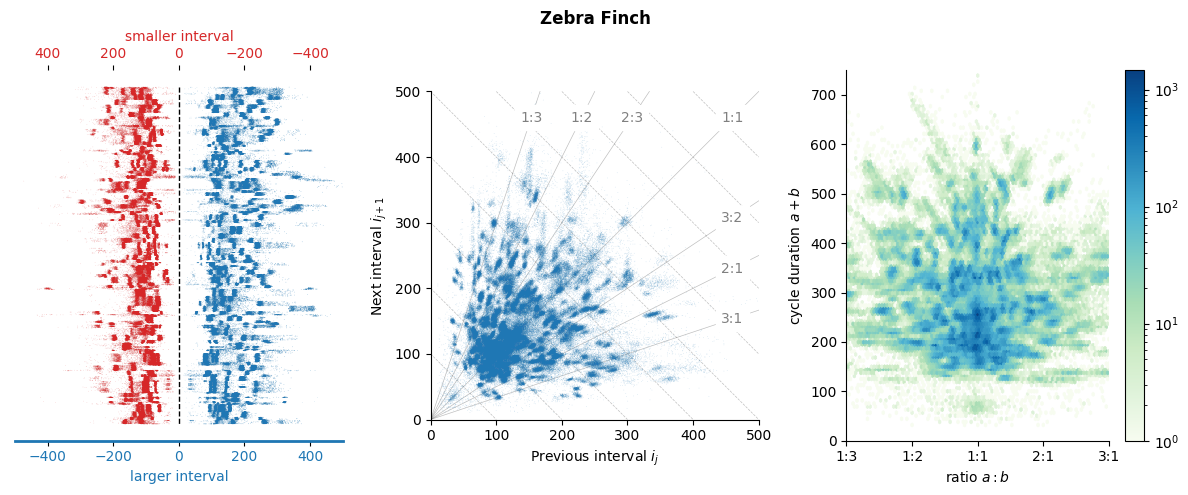

In [39]:
zebrafinch = load_intervals('roeske2020', 'zebrafinch') * 1000
plot_combined(zebrafinch, bound=500)
plt.suptitle('Zebra Finch', fontweight='bold')
save_combined('zebra-finch')